In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
BASE_DATA_FOLDER = "../input"
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")

In [3]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

In [4]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [5]:
def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')

In [6]:
images = []
labels = []

for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (150, 150))
        image = segment_plant(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        
        image = image.flatten()
        
        images.append(image)
        labels.append(class_folder_name)
        
images = np.array(images)
labels = np.array(labels)

In [7]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [8]:
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [9]:
images_scaled = StandardScaler().fit_transform(images)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
images_scaled.shape

(4750, 2025)

In [11]:
label_ids.shape

(4750,)

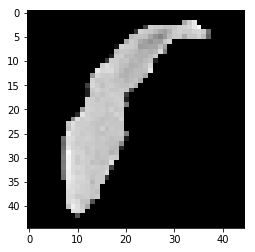

In [12]:
plt.imshow(np.reshape(images[734], (45,45)), cmap="gray")

## PCA

In [13]:
pca = PCA(n_components=180)
pca_result = pca.fit_transform(images_scaled)

In [14]:
pca_result.shape

(4750, 180)

## t-SNE after PCA

In [15]:
tsne = TSNE(n_components=2, perplexity=40.0)

In [16]:
tsne_result = tsne.fit_transform(pca_result)

In [17]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

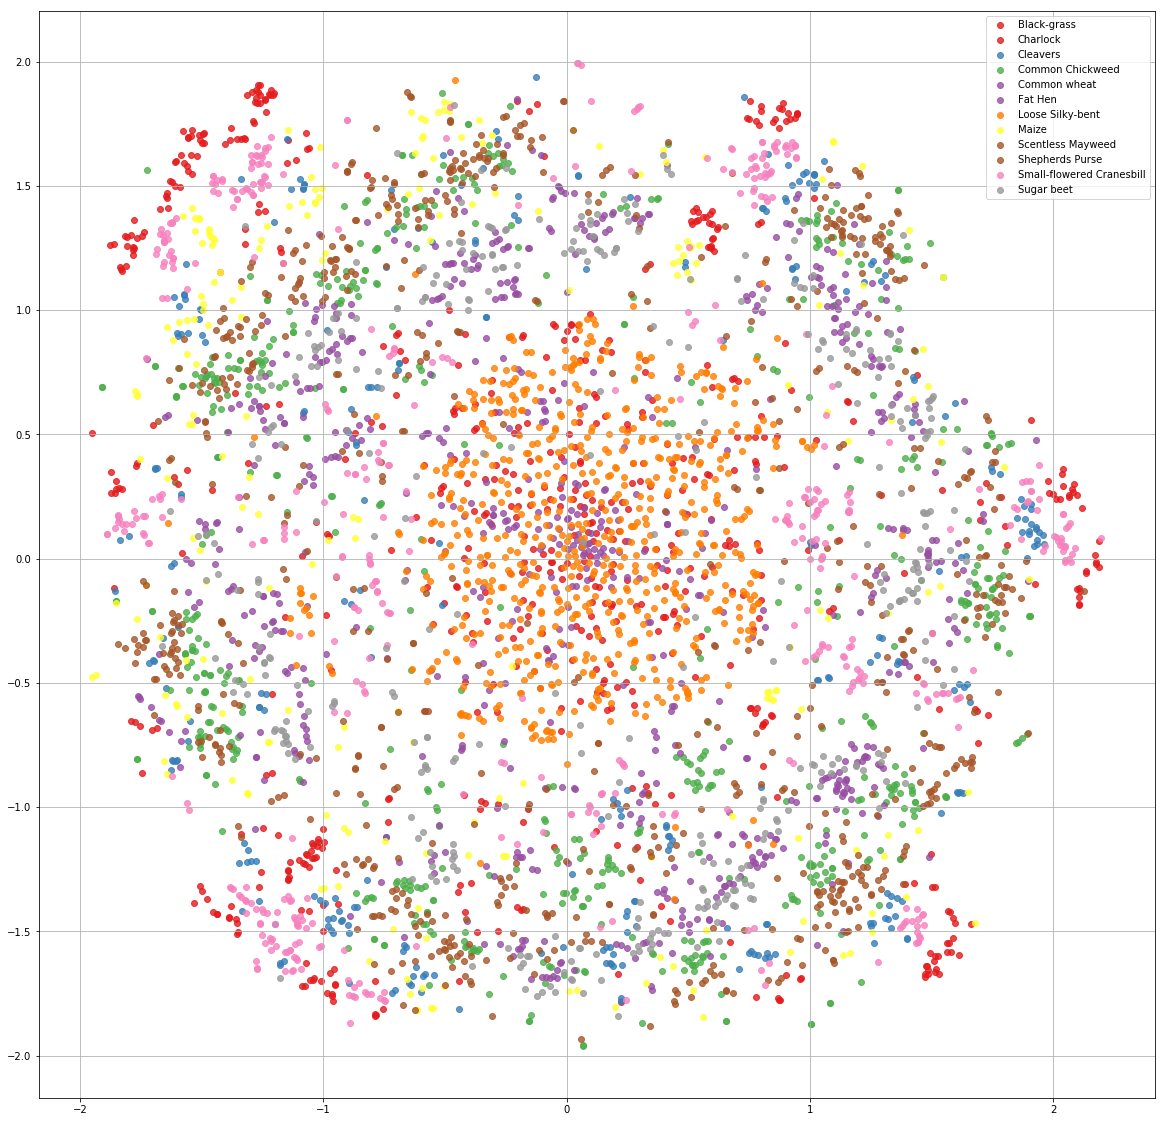

In [18]:
visualize_scatter(tsne_result_scaled, label_ids)

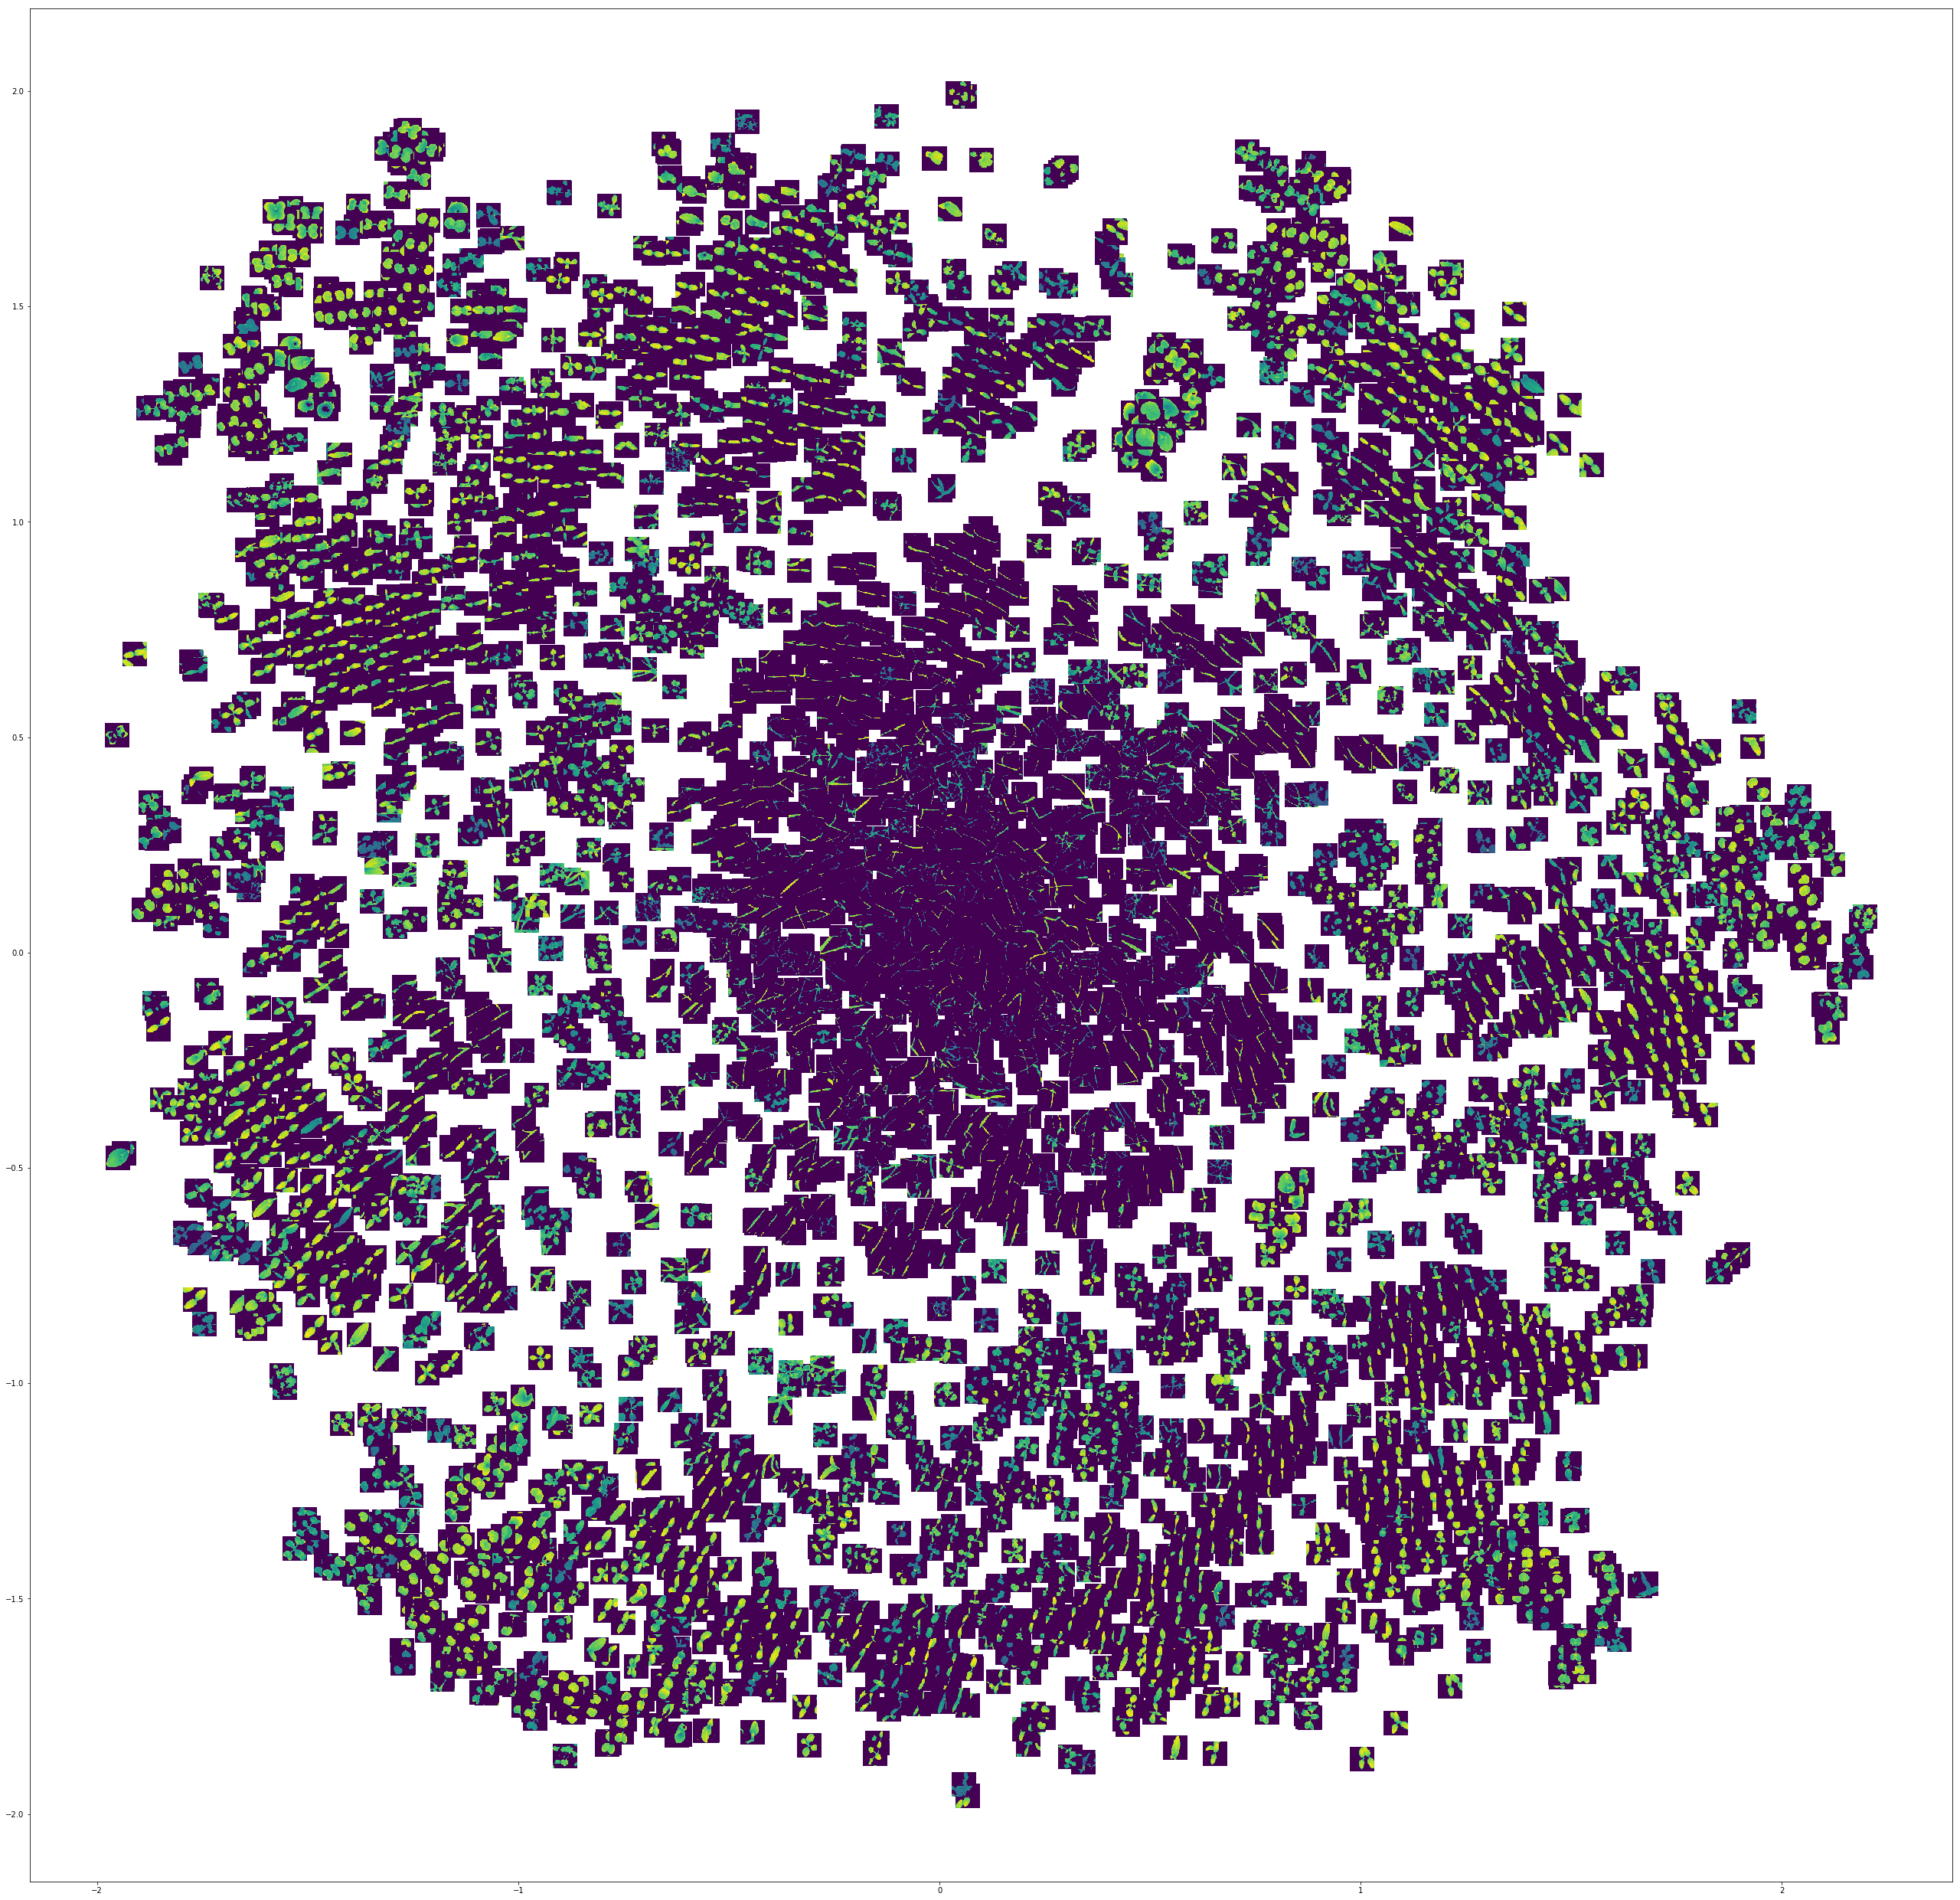

In [19]:
visualize_scatter_with_images(tsne_result_scaled, images = [np.reshape(i, (45,45)) for i in images], image_zoom=0.7)

## 3D t-SNE with animation

In [20]:
tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

(-2.5, 2.5)

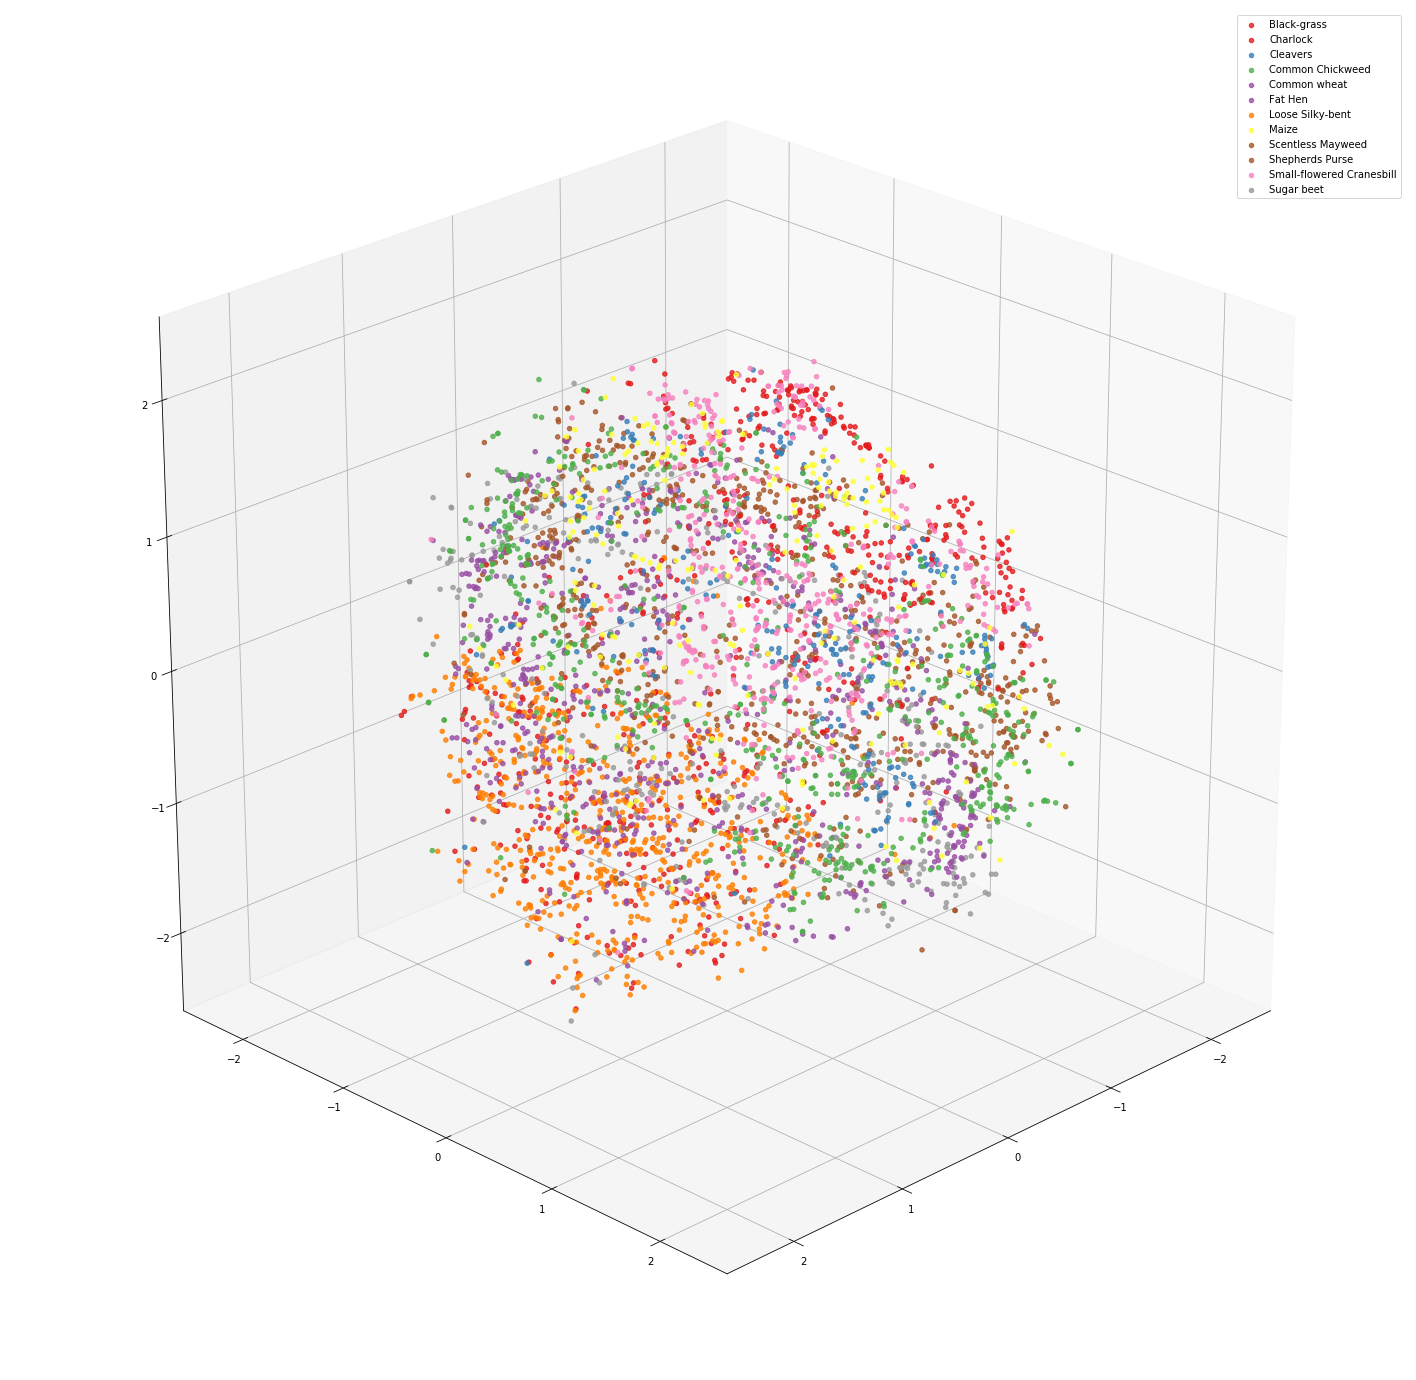

In [22]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111,projection='3d')

plt.grid()
    
nb_classes = len(np.unique(label_ids))
    
for label_id in np.unique(label_ids):
    ax.scatter(tsne_result_scaled[np.where(label_ids == label_id), 0],
                tsne_result_scaled[np.where(label_ids == label_id), 1],
                tsne_result_scaled[np.where(label_ids == label_id), 2],
                alpha=0.8,
                color= plt.cm.Set1(label_id / float(nb_classes)),
                marker='o',
                label=id_to_label_dict[label_id])
ax.legend(loc='best')
ax.view_init(25, 45)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)

In [26]:
anim = animation.FuncAnimation(fig, lambda frame_number: ax.view_init(30, 4 * frame_number), interval=75, frames=90)

In [24]:
plot_3d_animation_filename = 'animation.gif'
anim.save(plot_3d_animation_filename, writer='imagemagick')

In [25]:
import io
import base64
from IPython.display import HTML

video = io.open(plot_3d_animation_filename, 'r+b').read()
# HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(base64.b64encode(video).decode('ascii')))

With this last step we would get a neat little 3D scatter plot animation. I commented it, because the size of the gif can take up to 30MB and it slows down the whole notebook unfortunately. If you would like to try it out, just uncomment it and run the last cell. Or of course you can view it with any program because it is saved as `animation.gif` 